## Imports

In [1]:
import pandas as pd
import numpy as np
import random

import warnings

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import seaborn as sns

## Data

In [2]:
INFILE = "../data/sp500_returns.xlsx"

rets_spx = pd.read_excel(INFILE, sheet_name="s&p500 rets").set_index("date")
rets_bench = pd.read_excel(INFILE, sheet_name="benchmark rets").set_index("date")

In [3]:
TARGET = 'USO'

y = rets_bench[TARGET]
X = rets_spx

# Full Sample

In [4]:
def estimate_reg(X,y,model=LinearRegression,penalty=None,DoIntercept=True):
    if model is LinearRegression:
        est = LinearRegression(fit_intercept=DoIntercept).fit(X,y)
    else:
        est = model(alpha=penalty, fit_intercept=DoIntercept).fit(X,y)
    
    betas = pd.Series(index = X.columns, dtype=float)
    betas.loc[X.columns] = est.coef_
    
    if DoIntercept:
        betas = pd.concat([pd.Series(index=['intercept'], data=est.intercept_), betas]) 

    r2 = est.score(X,y)
    
    return betas, r2

### Setup

In [5]:
random.seed(10)
SPARSITY = 1/50

betas = pd.DataFrame(dtype=float, columns = ['OLS','OLS Random','Ridge','LASSO'])
rsquared = pd.DataFrame(dtype=float,index = betas.columns, columns=['full sample'])

### OLS

In [6]:
MODEL = LinearRegression
betas['OLS'], r2 = estimate_reg(X,y,model=MODEL)
rsquared.loc['OLS','full sample'] = r2

### OLS with random subset of regressors

In [7]:
nX = round(X.shape[1] * SPARSITY)

idx_random = random.sample(range(0,X.shape[1]),nX)
Xrandom = X.iloc[:,idx_random]

MODEL = LinearRegression
betas['OLS Random'], r2 = estimate_reg(Xrandom,y,model=MODEL)
rsquared.loc['OLS Random','full sample'] = r2

### Ridge

In [8]:
MODEL = Ridge

if TARGET=='USO':
    PENALTY_ridge = 1
elif TARGET=='GLD':
    PENALTY_ridge = .5

betas['Ridge'], r2 = estimate_reg(X,y,model=MODEL,penalty=PENALTY_ridge)
rsquared.loc['Ridge','full sample'] = r2

### LASSO

#### LASSO: Setting Penalty vs Number of Regressors

The LASSO approach requires that we set a penalty.
- Often, we prefer to set a total number of utilized (non-zero beta) regressors.
- Do this by trying a range of penalty parameters to achieve the desired number of utilized regressors.
- Below, we do this for `NUMBER_REGRESSORS` and a `while` loop.

In [9]:
NUMBER_REGRESSORS_TARGET = max(5,round(X.shape[1] * SPARSITY))

### Set initial penalty
if TARGET=='USO':
    penalty_init = 1e-4
    PENALTY_lasso_inc = 1e-6
elif TARGET=='GLD':
    penalty_init = 2e-5
    PENALTY_lasso_inc = 1e-7
        
PENALTY_lasso = penalty_init

n_regressors_init = (Lasso(alpha=PENALTY_lasso).fit(X,y).coef_ != 0).sum()

### Loop through penalty values until we find one that gets 3 non-zero beta estimates
while (Lasso(alpha=PENALTY_lasso).fit(X,y).coef_ != 0).sum() > NUMBER_REGRESSORS_TARGET:
    PENALTY_lasso += PENALTY_lasso_inc
    
n_regressors_derived = (Lasso(alpha=PENALTY_lasso).fit(X,y).coef_ != 0).sum()

In [10]:
df_penalties = pd.DataFrame({'nonzero regressors': [n_regressors_init, n_regressors_derived],
                             'penalty': [penalty_init, PENALTY_lasso]},
                            index=['ad hoc penalty','derieved penalty'])

display(df_penalties.style.format(formatter={'penalty': '{:.6f}'}))

,nonzero regressors,penalty
ad hoc penalty,56,0.000100
derieved penalty,9,0.000360


#### Estimate LASSO model

In [11]:
MODEL = Lasso
betas['LASSO'], r2 = estimate_reg(X,y,model=MODEL,penalty=PENALTY_lasso)
rsquared.loc['LASSO','full sample'] = r2

### Show Beta Estimates
Excluding beta estimates exactly equal to zero to get better view of LASSO histogram

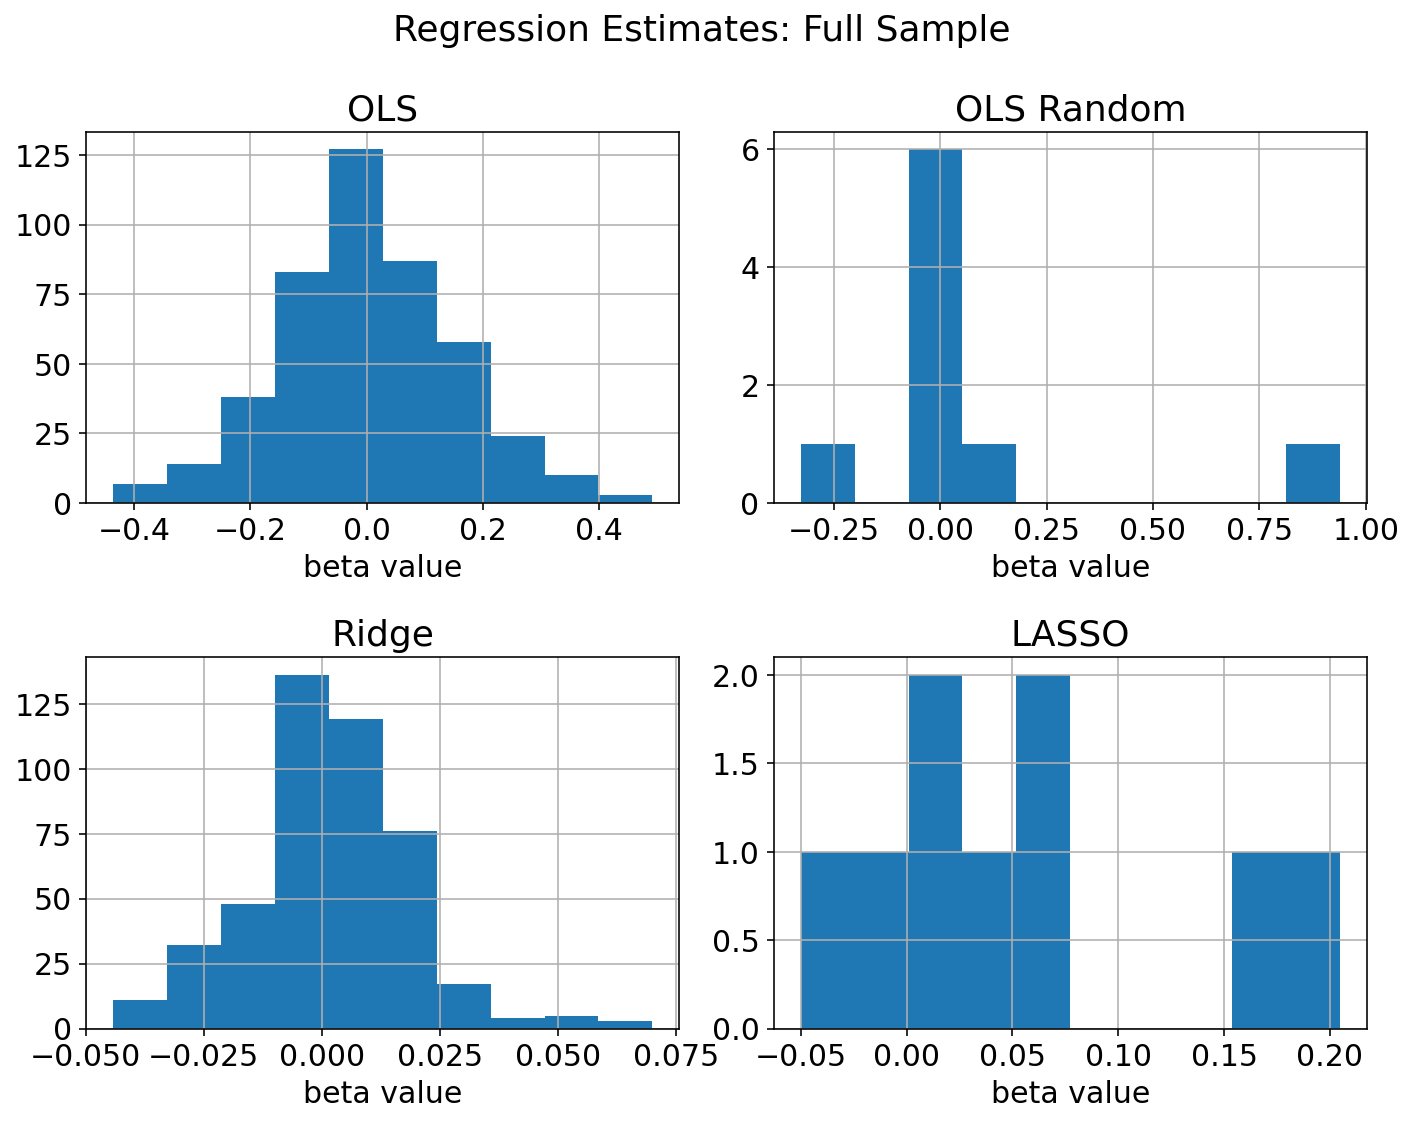

In [12]:
fig, ax = plt.subplots(2,2,figsize=(10,8))

for i,col in enumerate(betas.columns):
    temp = betas.loc[X.columns,col][betas.loc[X.columns,col]!=0]
    
    ax_id = (int(i/2),i%2)
    temp.hist(ax=ax[ax_id])
    ax[ax_id].set_title(col)
    ax[ax_id].set_xlabel('beta value')

plt.suptitle('Regression Estimates: Full Sample')
plt.tight_layout()
plt.show()

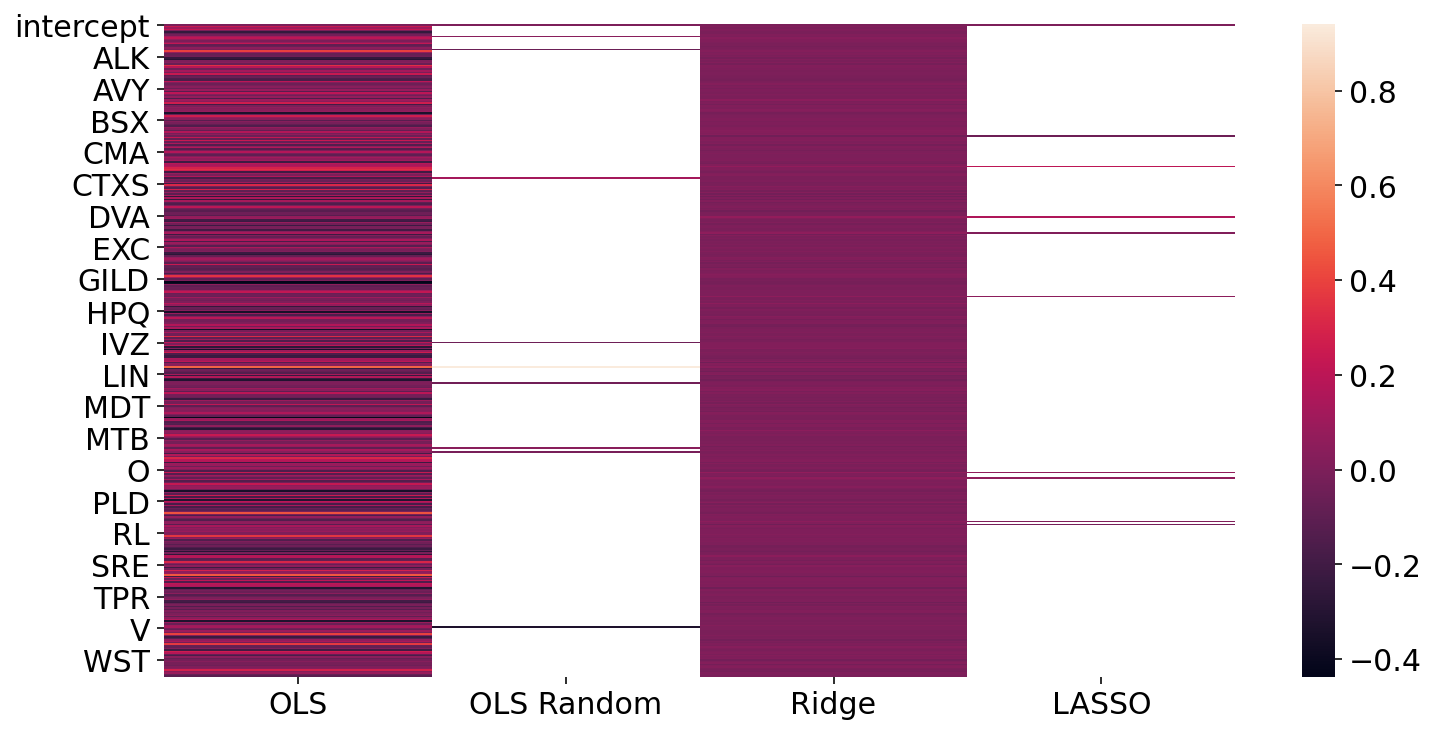

In [13]:
sns.heatmap(betas.replace(0,np.nan))
plt.show()

### Number of non-zero regressors

In [14]:
num_regressors = ((betas.abs()>0).sum()-1).to_frame().T.rename(index={0:'Number of nonzero betas'})
display(num_regressors)

,OLS,OLS Random,Ridge,LASSO
Number of nonzero betas,451,9,451,9


## R-squared

In [15]:
rsquared.style.format('{:.1%}')

,full sample
OLS,100.0%
OLS Random,17.2%
Ridge,68.7%
LASSO,40.8%


OLS has the largest $R^{2}$ which is not surprising at all as we are looking at in sample fit. OLS will fit the regressors to the regressand as well as it can in sample, while Ridge and LASSO will penalize when we weigh factors more heavily. As a result, OLS will fit better in sample, but it may be overfitting. 

# Multicollinearity

See the correlation matrices of 
* all regressors
* subset of regressors used in LASSO

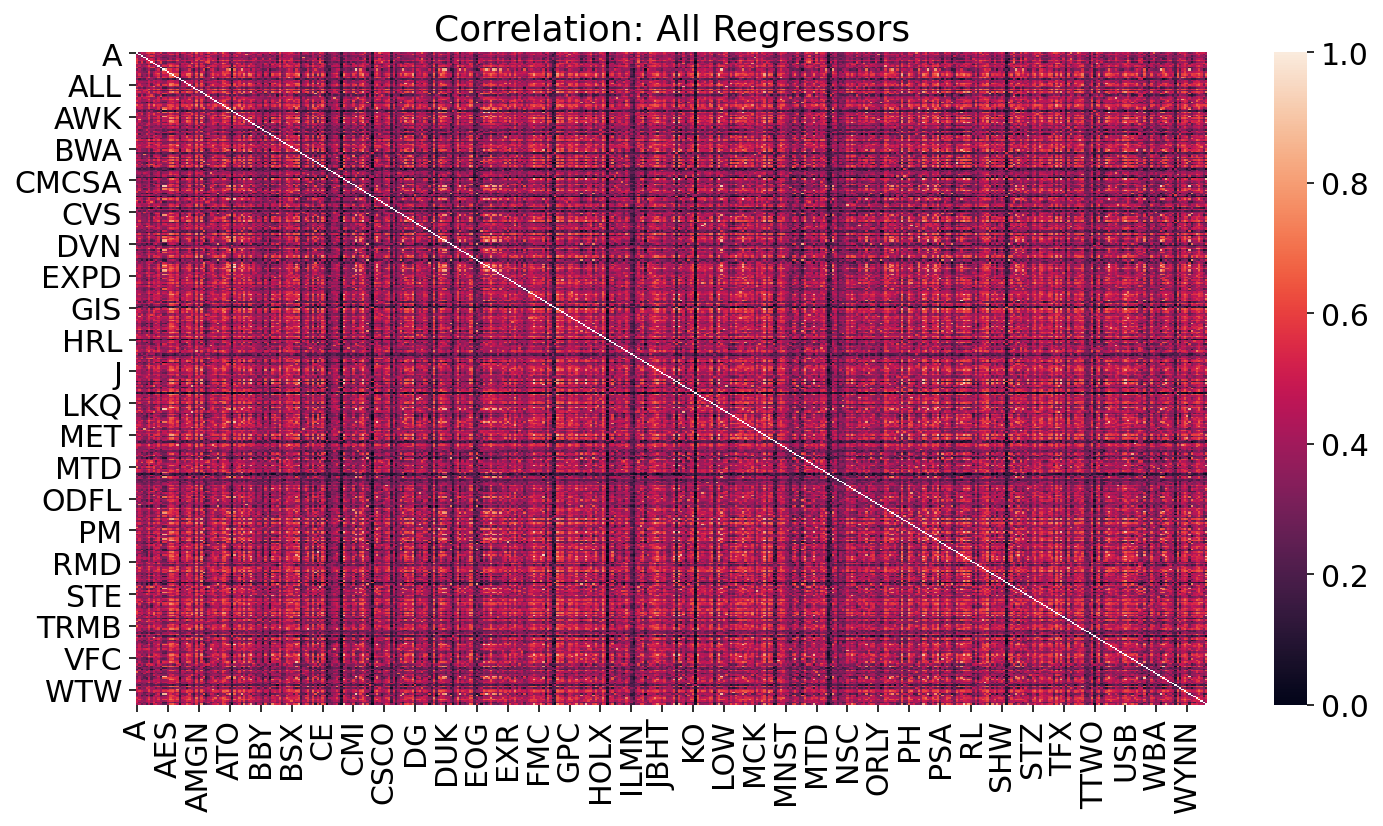

In [16]:
sns.heatmap(X.corr().replace(1,np.nan),vmin=0,vmax=1)
plt.title('Correlation: All Regressors')
plt.show()

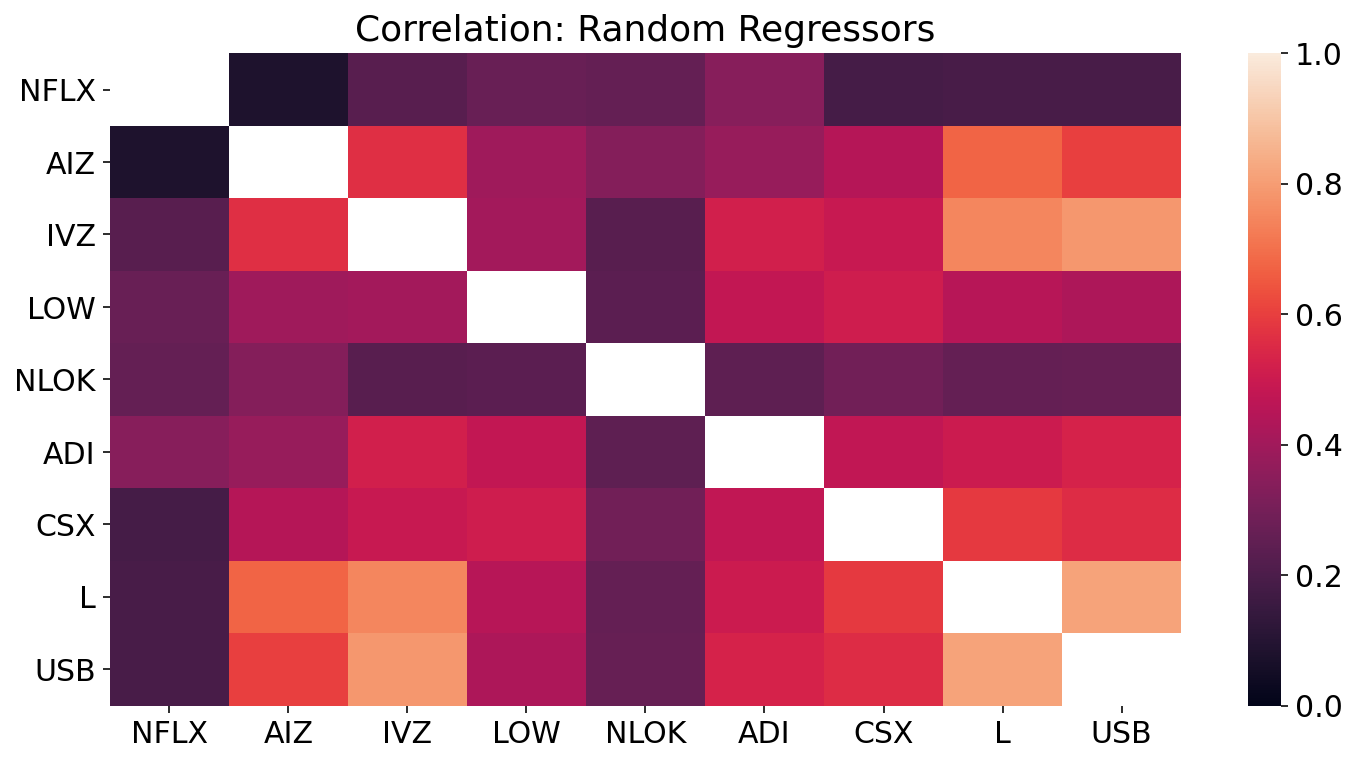

In [17]:
sns.heatmap(Xrandom.corr().replace(1,np.nan),vmin=0,vmax=1)
plt.title('Correlation: Random Regressors')
plt.show()

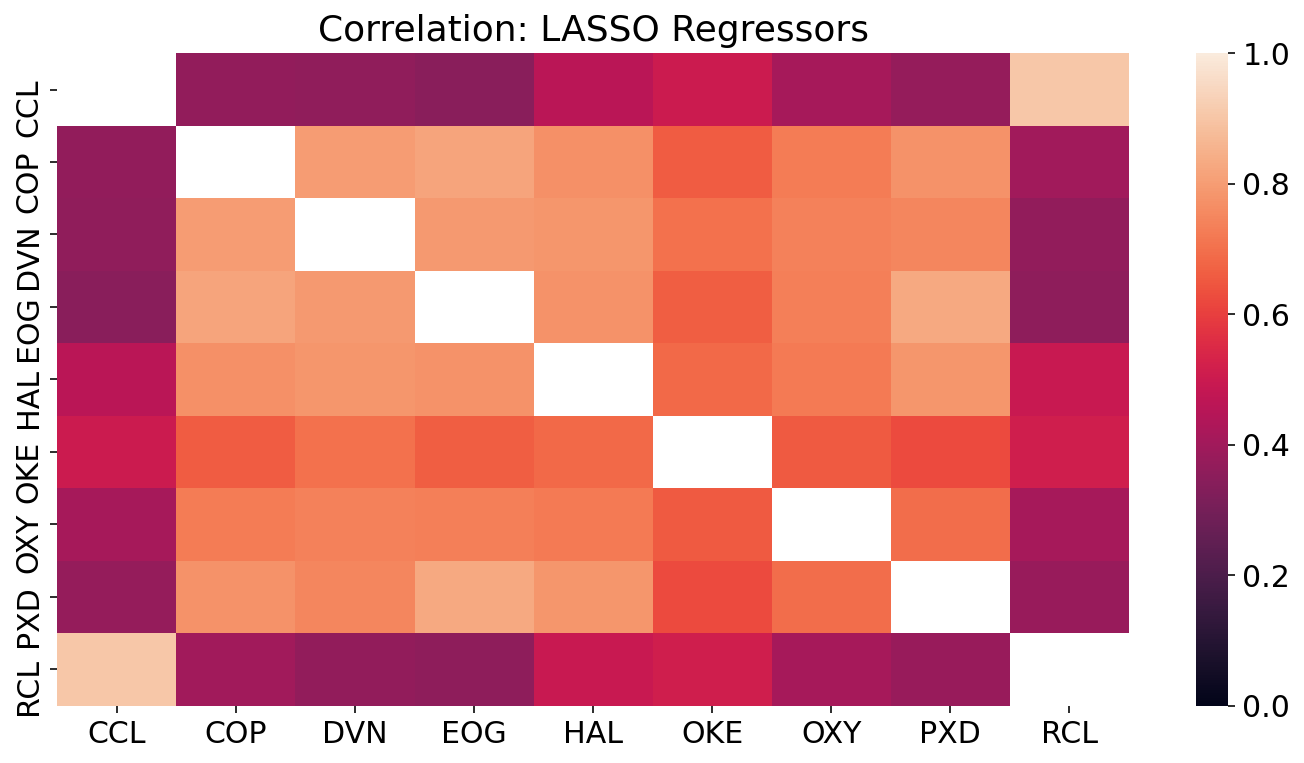

In [18]:
Xlasso = X.loc[:,(betas.loc[X.columns,'LASSO']!=0)]
sns.heatmap(Xlasso.corr().replace(1,np.nan),vmin=0,vmax=1)
plt.title('Correlation: LASSO Regressors')
plt.show()

### Condition Number of Design Matrices

In [19]:
condition_numbers = pd.DataFrame(columns=['matrix condition'],
                              index=['OLS','OLS Random','Ridge','LASSO'],
                              data=[np.linalg.cond(X.T@X), 
                                    np.linalg.cond(Xrandom.T @ Xrandom), 
                                    np.linalg.cond(X.T@X + np.diag(np.ones(X.shape[1])) * PENALTY_ridge),
                                    np.linalg.cond(Xlasso.T@Xlasso)                                    
                                   ])

condition_numbers['number of regressors'] = [X.shape[1], Xrandom.shape[1], X.shape[1], Xlasso.shape[1]]

condition_numbers.style.format('{:,.0f}')

,matrix condition,number of regressors
OLS,"7,633,374,997,321,928,704",451
OLS Random,36,9
Ridge,130,451
LASSO,56,9


# Test Sample

Consider a simple split of the sample. 

* Re-do your estimations, based on data through the sample split to fit the model
* Then test the model on the portion of the sample left out of the fit.

1. What is the $R^{2}$ in these out-of-sample fits?

2. Which method does better out-of-sample?

In [20]:
SPLIT_TRAIN = '2020'
SPLIT_TEST = '2021'

X_train = X[:SPLIT_TRAIN].copy()
y_train = y[:SPLIT_TRAIN].copy()
X_test = X[SPLIT_TEST:].copy()
y_test = y[SPLIT_TEST:].copy()

## Test Fit

In [21]:
ols_train = LinearRegression().fit(X_train,y_train)
ols_random_train = LinearRegression().fit(X_train.iloc[:,idx_random],y_train)
ridge_train = Ridge(alpha=PENALTY_ridge).fit(X_train,y_train)
lasso_train = Lasso(alpha=PENALTY_lasso).fit(X_train,y_train)

rsquared.loc[['OLS','OLS Random','Ridge','LASSO'],'test sample'] = [ols_train.score(X_test,y_test), 
                           ols_random_train.score(X_test.iloc[:,idx_random],y_test),
                           ridge_train.score(X_test,y_test),
                           lasso_train.score(X_test,y_test)]

rsquared.style.format('{:.1%}')

,full sample,test sample
OLS,100.0%,-122.5%
OLS Random,17.2%,-28.4%
Ridge,68.7%,47.0%
LASSO,40.8%,43.1%


## Cross-Validation
We parameterized the penalties for Ridge and LASSO with ad-hoc numbers above. Instead, try doing cross-validation. 

Make the entire sample available for the CV estimation.

Use the default number of folds.

### Test Sample Cross Validated

In [22]:
penalty_ridge_cv = RidgeCV(alphas=np.arange(.1,5,.1)).fit(X_train,y_train).alpha_

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    penalty_lasso_cv = LassoCV().fit(X_train,y_train).alpha_

ridge_cv = Ridge(alpha=penalty_ridge_cv).fit(X_test,y_test)
lasso_cv = Lasso(alpha=penalty_lasso_cv).fit(X_test,y_test)

rsquared.loc[['OLS','OLS Random','Ridge','LASSO'],'test sample CV'] = rsquared.loc[['OLS','OLS Random'],'test sample'].to_list() + [ridge_cv.score(X_test, y_test), lasso_cv.score(X_test, y_test)]
display(rsquared.style.format('{:.1%}'))

,full sample,test sample,test sample CV
OLS,100.0%,-122.5%,-122.5%
OLS Random,17.2%,-28.4%,-28.4%
Ridge,68.7%,47.0%,65.4%
LASSO,40.8%,43.1%,62.1%


# Out of Sample Estimation

### Step-by-step estimation

Let’s try back-testing the LASSO model, using the $\lambda$ value obtained from your CV in the
previous problem.
- Fit the model through `SPLIT_TRAIN`. 
- Evaluate the model fit for the OOS period. 
- Save the sample residual, the actual y value minus this OOS fit value.
- Repeat this same procedure, where in each iteration you fit the model through one month further, and you test the next step as the OOS value.
- With all of the saved OOS values, calculate the OOS $R^{2}$. 
- For the baseline, use the expanding mean of the target.

In [23]:
def calc_oos_regression(X,y,indx_split,model=LinearRegression,penalty=None,DoIntercept=True,doCV=False):

    ### Find starting index 
    starting_idx = len(X[:SPLIT_TRAIN])

    ### Initialize the error lists 
    err_x = np.array([])
    err_null = np.array([])

    for i in range(starting_idx, len(X)):
        ### Data up to t
        curr_X = X.iloc[:i]
        curr_y = y.iloc[:i]

        ### Fit the model on data through t-1
        if model is LinearRegression:
            mod = model(fit_intercept=DoIntercept).fit(curr_X, curr_y)
        else:
            if doCV:
                if model is Ridge:
                    penalty_use = RidgeCV(cv=5,alphas=np.arange(.8,1.2,.02) * penalty).fit(curr_X,curr_y).alpha_
                elif model is Lasso:
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore')
                        penalty_use = LassoCV(alphas= np.arange(.8,1.2,.02) * penalty, max_iter=1000).fit(curr_X,curr_y).alpha_
            else:
                penalty_use = penalty                
                    
            mod = model(alpha=penalty_use,fit_intercept=DoIntercept).fit(curr_X, curr_y)

        ### Reshape the matrix so we can input it to predict
        predict_y = mod.predict(X.iloc[i].values.reshape(1, -1))[0]

        ### Actual OOS value
        actual_y = y.iloc[i]

        ### The expanding mean is our baseline for OOS r2, curr_y has data from time 1 to time t-1
        expanding_mean = curr_y.mean()

        ### Append the errors, which we will use to calculate OOS r2
        err_x = np.append(err_x, actual_y - predict_y)
        err_null = np.append(err_null, actual_y - expanding_mean)
        
    r_sqr_oos = 1 - np.square(err_x).sum() / np.square(err_null).sum()
        
    return r_sqr_oos

In [24]:
doCV = False

colname = 'OOS static CV'
    
rsquared.loc['OLS',colname] = calc_oos_regression(X,y,SPLIT_TRAIN)
rsquared.loc['OLS Random',colname] = calc_oos_regression(Xrandom,y,SPLIT_TRAIN)
rsquared.loc['Ridge',colname] = calc_oos_regression(X,y,SPLIT_TRAIN,model=Ridge,penalty=penalty_ridge_cv,doCV=doCV)
rsquared.loc['LASSO',colname] = calc_oos_regression(X,y,SPLIT_TRAIN,model=Lasso,penalty=penalty_lasso_cv,doCV=doCV)


display(rsquared.style.format('{:.1%}'))

,full sample,test sample,test sample CV,OOS static CV
OLS,100.0%,-122.5%,-122.5%,-139.1%
OLS Random,17.2%,-28.4%,-28.4%,-6.7%
Ridge,68.7%,47.0%,65.4%,55.2%
LASSO,40.8%,43.1%,62.1%,44.6%


In [25]:
doCV = True

colname = 'OOS dynamic CV'
    
rsquared.loc['OLS',colname] = calc_oos_regression(X,y,SPLIT_TRAIN)
rsquared.loc['OLS Random',colname] = calc_oos_regression(Xrandom,y,SPLIT_TRAIN)
rsquared.loc['Ridge',colname] = calc_oos_regression(X,y,SPLIT_TRAIN,model=Ridge,penalty=penalty_ridge_cv,doCV=doCV)
rsquared.loc['LASSO',colname] = calc_oos_regression(X,y,SPLIT_TRAIN,model=Lasso,penalty=penalty_lasso_cv,doCV=doCV)


display(rsquared.style.format('{:.1%}'))

,full sample,test sample,test sample CV,OOS static CV,OOS dynamic CV
OLS,100.0%,-122.5%,-122.5%,-139.1%,-139.1%
OLS Random,17.2%,-28.4%,-28.4%,-6.7%,-6.7%
Ridge,68.7%,47.0%,65.4%,55.2%,54.5%
LASSO,40.8%,43.1%,62.1%,44.6%,46.4%
